v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

v6. Setting values that had been 0 to some very small number to avoid sending params to inf or -inf. For a 4x4 grid there are a few cells which would contain more than one ROI. Rather than overwriting the previous one we combine the two into one larger ROI.

v7. Going to 2x2 grid. There are a max of 4 ROIs per image, if we combine ones that occur in the same cell this may work better.

v8. Trying a 3x3 grid instead.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [2]:
GRID_SIZE = 3
location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        location_data[i,j,:] = [0, 390, 365, 225, 335]

In [3]:
img = pydicom.dcmread(os.path.join("stage_1_train_images", "cb4a1fca-136c-4577-bcef-d934c9f14f2c.dcm")).pixel_array

Below is an image which two ROIs in the same cell. The red boxes are the original ROIs, the blue is the new combined ROI.

In [4]:
1024 / 3

341.3333333333333

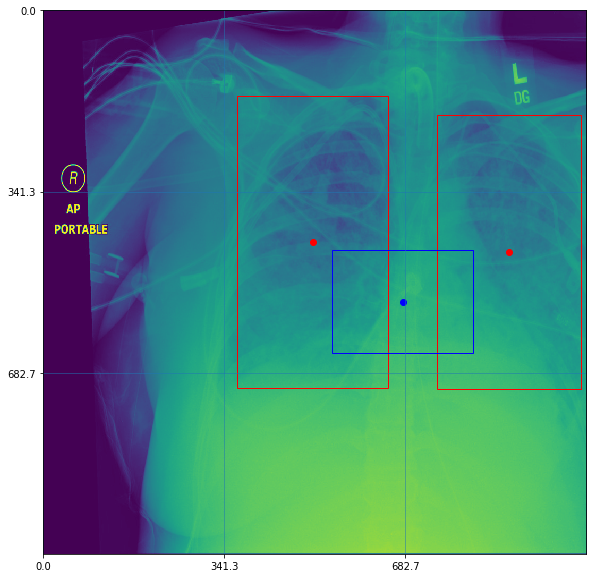

In [5]:
coords = np.arange(0, 1024, 1024 / GRID_SIZE)

# locs = [
#     [613,352,106,102],
#     [266,644,135,146],
#     [545,452,215,125],
#     [722,558,88,88]
# ]

locs = [
    [742,196,271,518],
    [365,162, 285, 549]
]

fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img)

for loc in locs:
    x,y,w,h = loc
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    
    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    plt.plot(center_x, center_y, marker="o", color="r")
    ax.add_patch(rect_1)

rect_1 = patches.Rectangle((545,452),265,194,linewidth=1,edgecolor='b',facecolor='none')
plt.plot((545 + (265/2)), (452 + (194/2)), marker="o", color="b")
ax.add_patch(rect_1)    
    
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
# plt.xlim(0,1024)
# plt.ylim(0,1024)
plt.show()

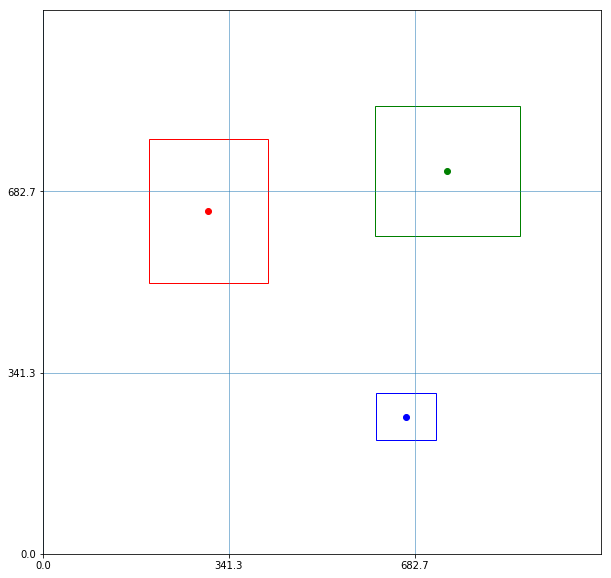

In [6]:
coords = np.arange(0, 1024, 1024 / GRID_SIZE)

fig,ax = plt.subplots(1, figsize=(10,10))

rect_1 = patches.Rectangle((195,511),218,271,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(304, 646.5, marker="o", color="r")
rect_2 = patches.Rectangle((612,214),109,89,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(666.5, 258.5, marker="o", color="b")
rect_3 = patches.Rectangle((610,599),265,245,linewidth=1,edgecolor='g',facecolor='none')
plt.plot(742.5, 721.5, marker="o", color="g")
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

In [7]:
boxes = [
    [195,511,218,271],
    [612,214,109,89],
    [610,599,265,245]
]

centers = []

for box in boxes:
    x,y,w,h = box
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    centers.append((center_x,center_y))

pixel_locs = []    
for center in centers:
    x_pixel = center[0] // 64
    y_pixel = center[1] // 64
    
    pixel_locs.append((x_pixel,y_pixel))
    
pixel_locs    

[(4.0, 10.0), (10.0, 4.0), (11.0, 11.0)]

In [8]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [9]:
# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

In [10]:
GRID_SIZE = 3
CELL_WIDTH = 1024 // GRID_SIZE

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

num_dups = 0

# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [0, 0.5, 0.5, 0.001, 0.001]
                    
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x / (1024 / GRID_SIZE))
            y_pixel = int(center_y / (1024 / GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            # special cases
            if GRID_SIZE == 5 and filename in ["085a6486-c3b3-4ca2-80f1-be07d23e853b", "0afeabf5-d5a3-454f-a50d-887f0d21106c", "1d57c801-71b4-49da-8933-2cabdc927fef", "49c04987-96af-4edb-b560-53c56a357cac"]:
                print(filename, x_pixel, y_pixel, x, y)
                if x == 332:
                    x_pixel = 2
                elif y == 443 and y_pixel == 2:
                    y_pixel = 1
                elif y == 332 and y_pixel == 2:
                    y_pixel = 1
                elif x == 351 and x_pixel == 2:
                    x_pixel = 1
                    
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            norm_center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            norm_center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # if more than one ROI exists in the same box, expand the ROI to include the new one
            if location_data[y_pixel,x_pixel,0] == 1:
                print("Dup:", filename)
                num_dups += 1
                # get the old location
                old_center_x, old_center_y, old_w, old_h = location_data[y_pixel, x_pixel, 1:]
                
                # unnormalize the old loc data
                old_w, old_h = old_w * 1024, old_h * 1024
                old_center_x = unnorm(old_center_x, x_pixel, CELL_WIDTH)
                old_center_y = unnorm(old_center_y, y_pixel, CELL_WIDTH)
                print(filename, "old center x:", old_center_x, "old_center_y:", old_center_y)
                print(filename, "new center x:", center_x, "new_center_y:", center_y)
                # convert to corners
                old_upper_corner_x = old_center_x - (old_w / 2)
                old_upper_corner_y = old_center_y - (old_h / 2)
                
                old_lower_corner_x = old_center_x + (old_w / 2)
                old_lower_corner_y = old_center_y + (old_h / 2)
                
#                 print("Old ROI:", old_upper_corner_x, old_upper_corner_y, old_w, old_h)
                
                # unnormalize the new data
                w = w * 1024
                h = h * 1024
                
#                 print("New ROI:", x, y, w, h)
                
                # new lower corner
                new_lower_corner_x = x + w
                new_lower_corner_y = y + h
                
#                 print("New Lower Corner:", new_lower_corner_x, new_lower_corner_y)
                
                # pick the furthest corner
                new_upper_corner_x = np.minimum(old_upper_corner_x, x)
                new_upper_corner_y = np.minimum(old_upper_corner_y, y)
                
                new_lower_corner_x = np.maximum(old_lower_corner_x, new_lower_corner_x)
                new_lower_corner_y = np.maximum(old_lower_corner_y, new_lower_corner_y)
                
                # get the new height and width
                new_w = new_lower_corner_x - new_upper_corner_x
                new_h = new_lower_corner_y - new_upper_corner_y
                
                # get the new center
                new_center_x = new_upper_corner_x + (new_w / 2)
                new_center_y = new_upper_corner_y + (new_h / 2)
                
#                 print("Combined ROI:", new_upper_corner_x, new_upper_corner_y, new_w, new_h)
                
                # normalize the new center
                new_center_x = (new_center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
                new_center_y = (new_center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
                
                # renormalize the new height and width
                new_w = new_w / 1024
                new_h = new_h / 1024
                
#                 print("New Label:", new_center_x, new_center_y, new_w, new_h)
                
                norm_center_x = new_center_x
                norm_center_y = new_center_y
                w = new_w
                h = new_h
                
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = norm_center_x
            location_data[y_pixel,x_pixel,2] = norm_center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
            
            if w > 0.6:
                print(filename,"width", w)
                pass
            if h > 0.6:
#                 print(filename,"height", h)
                pass
        else:
            pass
        
        locations.append(location_data[:,:,:])
        pixel_means.append(np.mean(locs))
        pneumonia_locations[filename] = location_data
        
print("Mean pos:", np.mean(pixel_means))        

Dup: 01fa0f5e-00c3-41cb-b5c7-10600c8633ae
01fa0f5e-00c3-41cb-b5c7-10600c8633ae old center x: 652.5 old_center_y: 488.5
01fa0f5e-00c3-41cb-b5c7-10600c8633ae new center x: 412.0 new_center_y: 479.5
Dup: 0a66f58c-f98d-41d1-89af-4e0136888e13
0a66f58c-f98d-41d1-89af-4e0136888e13 old center x: 681.5 old_center_y: 545.5
0a66f58c-f98d-41d1-89af-4e0136888e13 new center x: 358.5 new_center_y: 575.5
Dup: 0ab261f9-4eb5-42ab-a9a5-e918904d6356
0ab261f9-4eb5-42ab-a9a5-e918904d6356 old center x: 666.0 old_center_y: 403.0
0ab261f9-4eb5-42ab-a9a5-e918904d6356 new center x: 652.5 new_center_y: 514.5
Dup: 0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15
0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15 old center x: 677.0 old_center_y: 419.5
0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15 new center x: 351.5 new_center_y: 510.5
Dup: 0d5bc737-03de-4bb8-98a1-45b7180c3e0f
0d5bc737-03de-4bb8-98a1-45b7180c3e0f old center x: 416.0 old_center_y: 213.5
0d5bc737-03de-4bb8-98a1-45b7180c3e0f new center x: 678.0 new_center_y: 225.5
Dup: 12b4c5bc-48cb-4

Dup: 42705f2c-8bdc-4a9d-8e13-864b0a89be21
42705f2c-8bdc-4a9d-8e13-864b0a89be21 old center x: 346.5 old_center_y: 595.5
42705f2c-8bdc-4a9d-8e13-864b0a89be21 new center x: 631.5 new_center_y: 571.5
Dup: 4525bf0b-20b4-4f4f-9149-e32632812d89
4525bf0b-20b4-4f4f-9149-e32632812d89 old center x: 397.0 old_center_y: 581.0
4525bf0b-20b4-4f4f-9149-e32632812d89 new center x: 661.5 new_center_y: 558.0
Dup: 46c48199-1dcc-469c-ba56-f7a741dbfc50
46c48199-1dcc-469c-ba56-f7a741dbfc50 old center x: 678.5 old_center_y: 455.0
46c48199-1dcc-469c-ba56-f7a741dbfc50 new center x: 345.0 new_center_y: 388.0
Dup: 4736f2b8-2834-467c-a8a4-49fbd25a18af
4736f2b8-2834-467c-a8a4-49fbd25a18af old center x: 342.0 old_center_y: 388.5
4736f2b8-2834-467c-a8a4-49fbd25a18af new center x: 642.0 new_center_y: 446.0
Dup: 47761814-5258-4ba7-879c-a60bb9f68029
47761814-5258-4ba7-879c-a60bb9f68029 old center x: 677.0 old_center_y: 470.0
47761814-5258-4ba7-879c-a60bb9f68029 new center x: 357.0 new_center_y: 409.5
Dup: 49c04987-96af-4

Dup: 8fa2efa3-f8c8-4b89-9c22-e6468ec696d8
8fa2efa3-f8c8-4b89-9c22-e6468ec696d8 old center x: 500.5 old_center_y: 395.5
8fa2efa3-f8c8-4b89-9c22-e6468ec696d8 new center x: 672.5 new_center_y: 473.5
Dup: 904070bc-c210-47ef-b886-abb6b0dd7ee3
904070bc-c210-47ef-b886-abb6b0dd7ee3 old center x: 368.0 old_center_y: 571.5
904070bc-c210-47ef-b886-abb6b0dd7ee3 new center x: 680.5 new_center_y: 635.5
Dup: 93727b85-2fa2-478d-aecc-46e14f391dd5
93727b85-2fa2-478d-aecc-46e14f391dd5 old center x: 642.5 old_center_y: 485.5
93727b85-2fa2-478d-aecc-46e14f391dd5 new center x: 374.0 new_center_y: 474.0
Dup: 93a95c68-c487-4e09-89e2-6e3849e44886
93a95c68-c487-4e09-89e2-6e3849e44886 old center x: 387.5 old_center_y: 508.5
93a95c68-c487-4e09-89e2-6e3849e44886 new center x: 633.5 new_center_y: 552.5
Dup: 93eb36cf-5356-4be3-b740-1c4d7a842741
93eb36cf-5356-4be3-b740-1c4d7a842741 old center x: 368.5 old_center_y: 506.0
93eb36cf-5356-4be3-b740-1c4d7a842741 new center x: 672.0 new_center_y: 454.0
Dup: 94fd8652-cb5a-4

Dup: e3884258-8083-4b8e-b952-9adc91a7f0f3
e3884258-8083-4b8e-b952-9adc91a7f0f3 old center x: 333.5 old_center_y: 370.5
e3884258-8083-4b8e-b952-9adc91a7f0f3 new center x: 237.5 new_center_y: 633.0
Dup: e6dc5d04-2f76-425f-99d7-cae3aa095122
e6dc5d04-2f76-425f-99d7-cae3aa095122 old center x: 345.0 old_center_y: 524.0
e6dc5d04-2f76-425f-99d7-cae3aa095122 new center x: 676.0 new_center_y: 402.0
Dup: e75caca3-22a7-48dc-9b2d-d6e19db6bb29
e75caca3-22a7-48dc-9b2d-d6e19db6bb29 old center x: 279.5 old_center_y: 358.5
e75caca3-22a7-48dc-9b2d-d6e19db6bb29 new center x: 262.0 new_center_y: 662.0
Dup: ebd4509c-0b8f-4be2-aa51-bebad08235be
ebd4509c-0b8f-4be2-aa51-bebad08235be old center x: 378.5 old_center_y: 451.0
ebd4509c-0b8f-4be2-aa51-bebad08235be new center x: 380.5 new_center_y: 636.5
Dup: ec910555-f698-4536-aff7-7fa9d3405d60
ec910555-f698-4536-aff7-7fa9d3405d60 old center x: 245.0 old_center_y: 575.5
ec910555-f698-4536-aff7-7fa9d3405d60 new center x: 289.0 new_center_y: 359.5
Dup: ee820aa5-4804-4

In [11]:
num_dups

139

In [12]:
# save our dict to disk
with open('yolo_labels_centered_3x3_8b.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
locs = np.array(locations)
idx = locs[:,:,:,3] == 0.625

In [25]:
locs[idx]

array([[1.        , 0.35351562, 0.85546875, 0.625     , 0.5390625 ],
       [1.        , 0.35351562, 0.85546875, 0.625     , 0.5390625 ]])

In [14]:
with open('yolo_labels_centered_2x2_7.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [94]:
foo = pneumonia_locations["0ab261f9-4eb5-42ab-a9a5-e918904d6356"]

Look at some sample images to make sure the labels have been properly written.

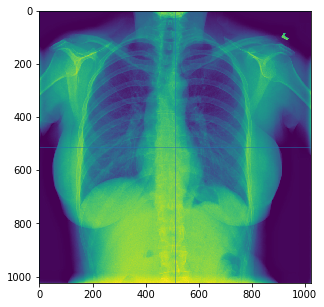

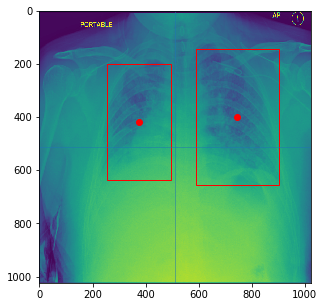

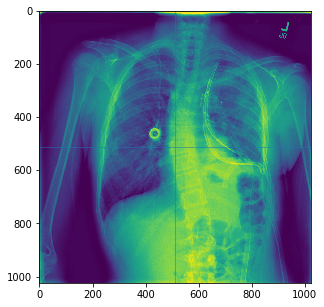

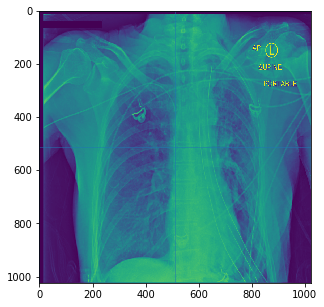

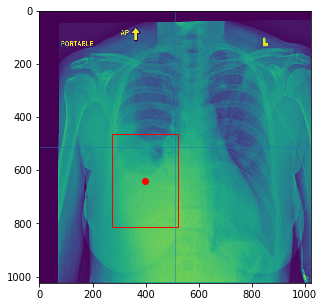

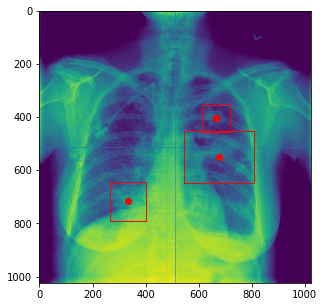

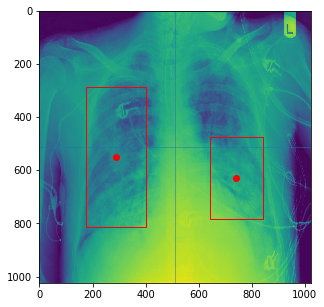

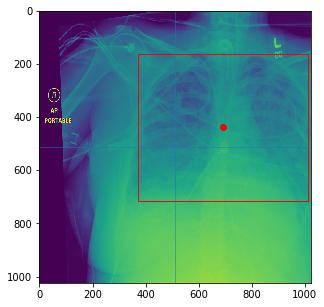

In [18]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, 512)

samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 1e-16:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                x = unnorm(x, j, 512)
                y = unnorm(y, i, 512)
                
                plt.plot(x, y, marker="o", color="r")
                
                x = x - (w / 2)
                y = y - (h / 2)
                
                rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
        
    plt.show()